In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import DecomposeResult

register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)


# 1 - Data Exploration

## 1. Loading the Data

In [18]:
df1 = pd.read_csv('./data/shop_1_transactions.csv',sep=';')
df1['date'] = pd.to_datetime(df1['date'])

## 2. Analysis of the daily quantity sales 

We start by extracting the daily sales of the most popular item and plot the results. The data contains 1625 rows and has a mean of 50 daily quantity sales.

,quantity
count,1625.000000
mean,50.051385
std,51.559993
min,0.000000
25%,17.000000
50%,38.000000
75%,65.000000
max,320.000000


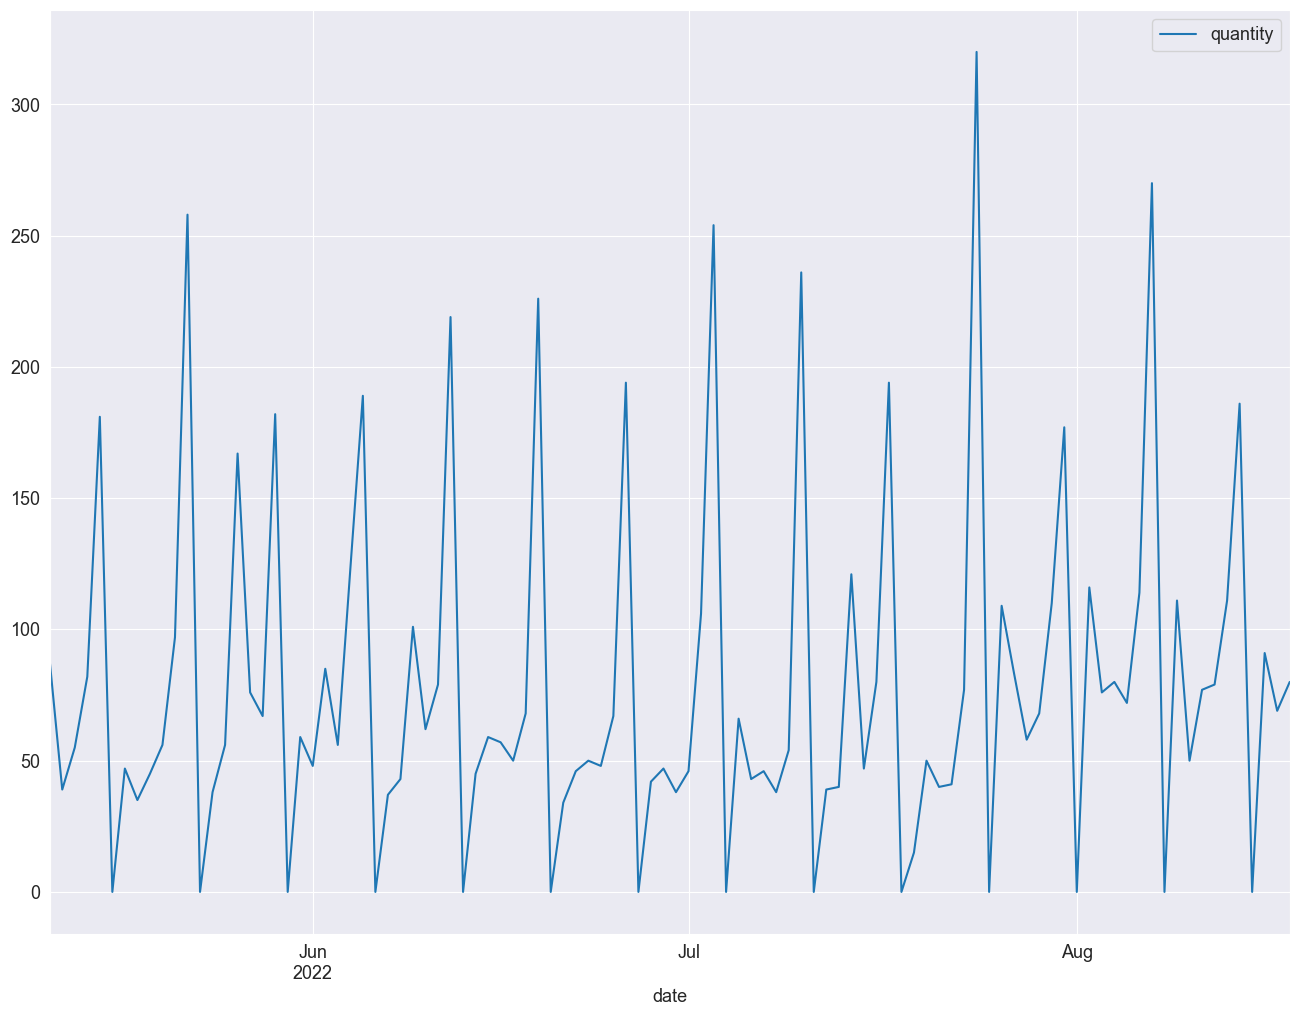

In [70]:
# get the list of the 10 most popular items
popular_item_ids = df1.groupby(['item_id'])['quantity'].sum().sort_values(ascending=False).index[0:10]

# load the sales of the most popular item 
item_df = df1[df1['item_id'] == popular_item_ids[0]]

# remove outlierz with the zscore method
item_df = item_df[np.abs(zscore(item_df['quantity'])) < 2]

# get the data grouped by day
ts = item_df.set_index('date').resample('D')[['quantity']].sum()

# plot the last 100 rows
ts.tail(100).plot()

ts.describe()

We can now plot the distribution and see how the time series seems to normally distributed with a zero inflated left tail.

array([[<Axes: title={'center': 'quantity'}>]], dtype=object)

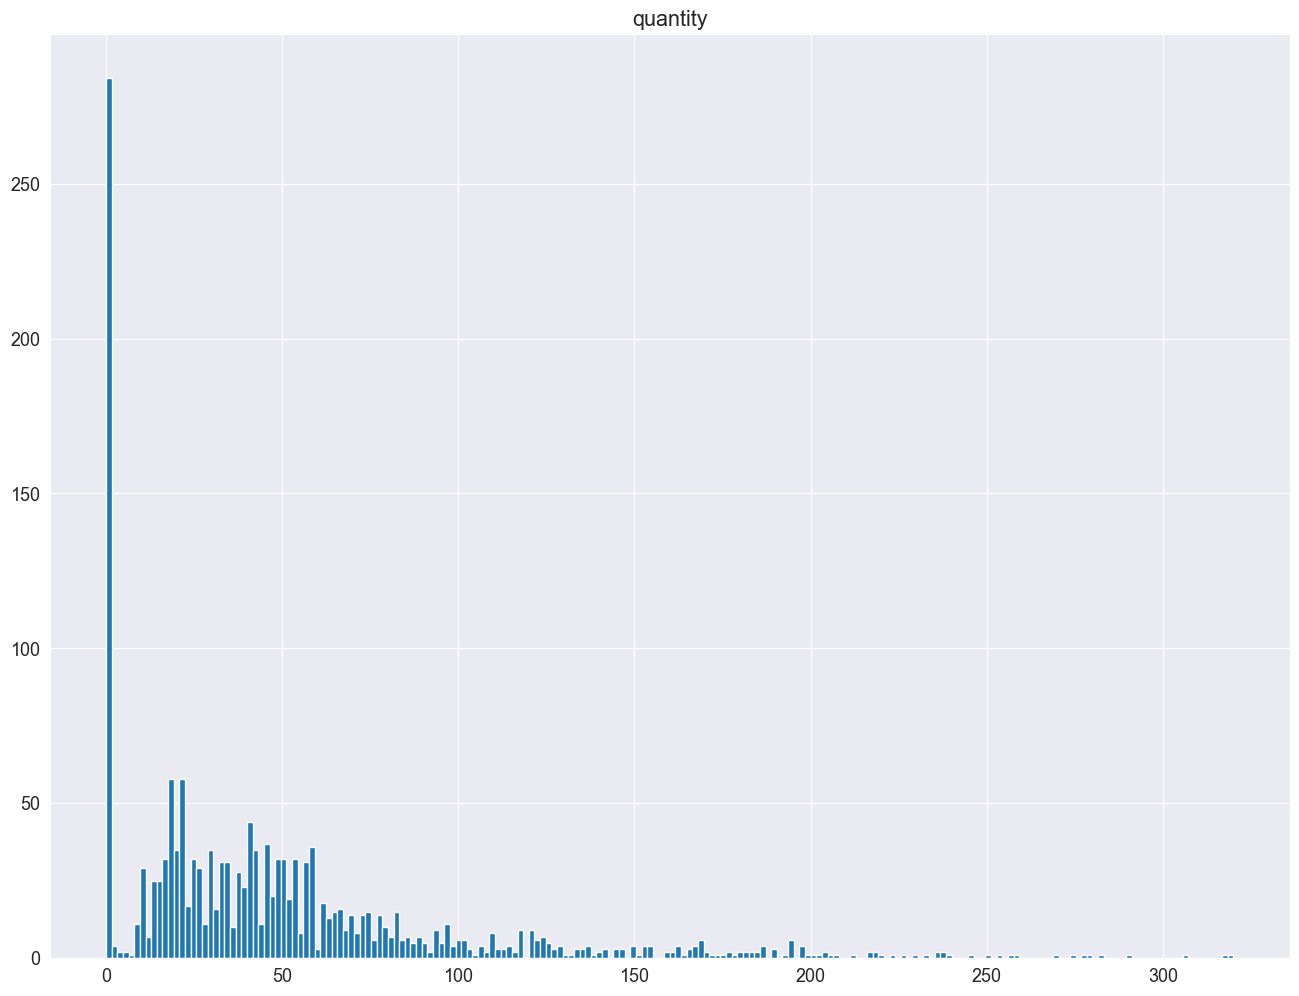

In [69]:
# plot the distribution of the data
ts.hist(bins=200)

By looking at the shape of the time series, we would be tempted to do a seasonal decomposition in order to extract the trend and the seasonal component of the time series for this specific item.

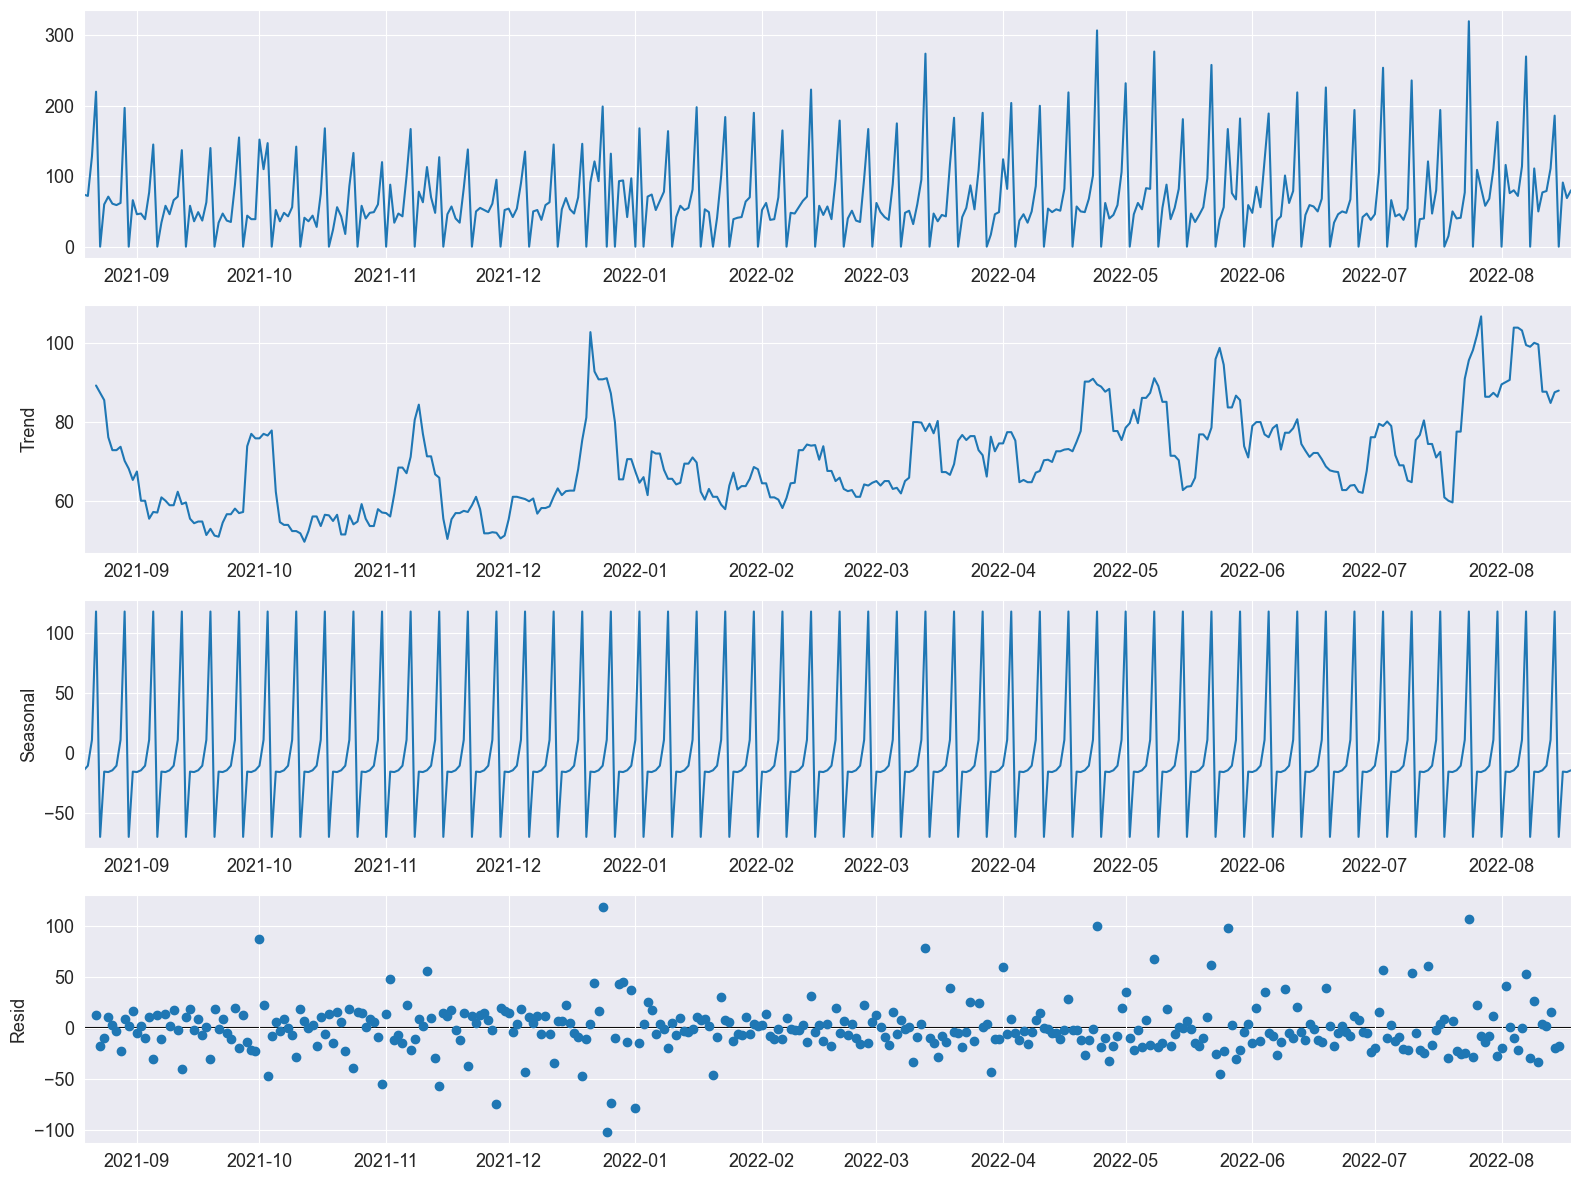

In [72]:
# decompose the time series by seasonal + trend + residuals components
# we only decompose the last 365 rows to better plot the result.
dec = seasonal_decompose(ts.tail(365),period=7)

dec.plot()
None

# 2. Data Engineering.

# 2.1 Smoothing the series

In [ ]:
from typing import Callable
from matplotlib import pyplot as plt
import pandas as pd
from scipy.signal import medfilt, wiener
from scipy.ndimage import gaussian_filter


class SmoothSerie:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self._is_date_index = df.index.name == 'date'

    def _base_applicator(self, func: Callable[[pd.Series], pd.Series], key):
        df = self.df.copy()

        if self._is_date_index:
            df = df.reset_index(drop=False)

        df['buff_weekday'] = pd.to_datetime(df['date']).dt.weekday

        if type(key) != list:
            key = [key]

        res = []
        for weekday in range(7):
            day_df = df[
                df['buff_weekday'] == weekday
            ].copy().reset_index(drop=False)

            for k in key:
                day_df[k] = func(day_df[k])

            res.append(day_df)

        final_df = pd.concat(res).sort_values(by=['index'])

        final_df = final_df.drop(['index', 'buff_weekday'], axis=1)

        final_df = final_df.reset_index(drop=True)

        if self._is_date_index:
            final_df = final_df.set_index('date')

        return final_df

    def ewm(self, key: str, alpha: float = 0.5):
        return self._base_applicator(lambda x: x.ewm(alpha=alpha, adjust=False).mean(), key)

    def rolling(self, key: str, window: float = 5):
        return self._base_applicator(lambda x: x.rolling(window, min_periods=1, closed='both').mean(), key)

    def med_filtering(self, key: str, kernel_size=3):
        return self._base_applicator(lambda x: medfilt(x, kernel_size), key)

    def gaussian_filtering(self, key: str, sigma):
        return self._base_applicator(lambda x: gaussian_filter(x, sigma), key)

    def wiener_filtering(self, key: str):
        return self._base_applicator(lambda x: wiener(x), key)

## 2.2